In [1]:
import glob
import os
import re
import shutil
import random
import string
import sys

import numpy as np
import pandas as pd

import nilearn
from nilearn import plotting, image
from nilearn.input_data import NiftiMasker
import nibabel as nib
from nipype.interfaces import ants
import nighres

import subprocess
import json
import multiprocessing as mp
from functools import partial
import joblib
from joblib import Parallel, delayed
import itertools
from utils import apply_warp

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/home/atrutti1/miniconda3/lib/python3.8/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


# 1. Warp ATAG masks to T1w space
We have all masks in MNI2009cAsym 1 mm space; hence, applying the composite warp to T1w and then the affine to functional data.

These masks are from ATAG, Harvard-Oxford, combined with a binary preSMA mask (based on coordinates from Johannsen-Berg), the VTA masks from Anne and the recently published LC masks. Ie, they're a pot-pourri, useful for checking things

In [3]:
all_subjects = [x.split('/')[-2].split('-')[-1] for x in sorted(glob.glob('../derivatives/fmriprep/fmriprep/sub*/ses-anatomical'))]
# all_subjects = ['002','003','004','005','006','007','008','009','010','011']
# all_subjects = ['012','013','014','015','016']
# all_subjects = ['017','018','019','020','021']
# all_subjects = ['022','023','024','025','026']
# all_subjects = ['027','029','030','031','032']
# all_subjects = ['043','044']

def warp_masks_2_t1w(sub, overwrite=True):
    print(sub)
    regex_masks = re.compile('.*/space-MNI152NLin2009cAsym_label-(?P<label>\S+)_probseg.nii.gz')
    all_masks = sorted(glob.glob('../sourcedata/masks/MNI152NLin2009cAsym/*.nii.gz'))
    
    output_img_base = f'../derivatives/masks_atag_func/sub-{sub}/anat/sub-{sub}_space-T1w_desc-mask-{{label}}.nii.gz'
    
    for mask in all_masks:
        mask_label = regex_masks.match(mask).groupdict()['label']
        
        final_img_fn = output_img_base.format(label=mask_label)
        if not os.path.exists(final_img_fn) or overwrite:
            os.makedirs(os.path.dirname(final_img_fn), exist_ok=True)
            tmp_img_name = apply_warp(mask, sub=sub, t1w_to_MNI=False)
            shutil.move(tmp_img_name, final_img_fn)
            
_ = [warp_masks_2_t1w(x) for x in all_subjects]
with mp.Pool(20) as p:
    p.map(warp_masks_2_t1w, all_subjects)
    
# warp_masks_2_t1w('042')

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026


TraitError: Each element of the 'transforms' trait of an ApplyTransformsInputSpec instance must be a pathlike object or string representing an existing file or 'identity', but a value of '../derivatives/fmriprep/fmriprep/sub-026/ses-anatomical/anat/sub-026_ses-anatomical_from-MNI152NLin2009cAsym_to-T1w_mode-image_xfm.h5' <class 'str'> was specified.

# 2. Downsample MASSP masks to functional resolution

Pilou runs MASSP using the multimodal anatomical qMRI data, which outputs binary masks in T1w-space / resolution *(plus posteriors, what to do with these?)*. For analyses of functional data, we need to downsample these. Here, we use linear interpolation.

In [2]:
# def warp_massp_map(args, atlas, target_img):
#     label_n, label = args
#     random.seed(label_n)
#     this_map = atlas.get_fdata().copy()
#     this_map[this_map!=(label_n+1)] = 0
#     this_map[this_map>0] = 1
#     this_map_nii = nib.Nifti1Image(this_map, atlas.affine)

#     # ok now we need to do this rather annoying temporary save thing agian
#     tmp_name = './tmp_img_to_warp-{}.nii.gz'.format(''.join(random.choices(string.ascii_letters + string.digits, k=10)))
#     this_map_nii.to_filename(tmp_name)

#     out = nighres.registration.embedded_antsreg(source_image=tmp_name, 
#                                                 target_image=target_img,
#                                                 run_rigid=True, rigid_iterations=0, 
#                                                 run_affine=False, run_syn=False, overwrite=True, 
#                                                 interpolation='Linear', save_data=True, output_dir='./', file_name=f'{tmp_name}_warp.nii.gz')
#     warped_img = out['transformed_sources'][0]
#     warped_data = warped_img.get_fdata()

#     # clean-up
#     os.remove(tmp_name)
#     os.remove(f'{tmp_name}_warp_ants-def0.nii.gz')
#     os.remove(f'{tmp_name}_warp_ants-map.nii.gz')
#     os.remove(f'{tmp_name}_warp_ants-invmap.nii.gz')
#     return {label: nib.Nifti1Image(warped_data.copy(), header=warped_img.header, affine=warped_img.affine)}

def warp_massp_map(args, atlas, target_img):
    label_n, label = args
    this_map = atlas.get_fdata().copy()
    this_map[this_map!=(label_n+1)] = 0
    this_map[this_map>0] = 1
    this_map_nii = nib.Nifti1Image(this_map, atlas.affine)

    # ok now we need to do this rather annoying temporary save thing agian
    resampled_img = nilearn.image.resample_to_img(source_img=this_map_nii, target_img=target_img, interpolation='linear')
    return {label: resampled_img}

def load_MASSP_atlas_1p5mm(sub,overwrite=True): 
    labels_17structures = ['Str-l','Str-r','STN-l','STN-r','SN-l','SN-r',\
                           'RN-l','RN-r','GPi-l','GPi-r','GPe-l','GPe-r',\
                           'Tha-l','Tha-r','LV-l','LV-r','3V','4V','Amg-l','Amg-r',\
                           'ic-l','ic-r','VTA-l','VTA-r','fx','PAG-l','PAG-r',\
                           'PPN-l','PPN-r','Cl-l','Cl-r']

    # save fns
    save_fn_template = f'../derivatives/masks_massp_func/sub-{sub}/anat/sub-{sub}_space-T1w_desc-mask-{{}}.nii.gz'
    if os.path.exists(save_fn_template.format('Str-l')) and not overwrite:
        # Already warped, load atlas
        maps = {}
        for label in labels_17structures:
            maps[label] = nib.load(save_fn_template.format(label))
        
    else:
        atlas_fn = os.path.join('..', 'derivatives', 'nighres', f'sub-{sub}', 'ses-anatomical', 'subcortex', f'sub-{sub}_ses-anatomical_massp-labels.nii.gz')
        if not os.path.exists(atlas_fn):
            print(f'MASSP not yet run for sub-{sub} (returning 0 to prevent break)')
            return 0
        target_img = sorted(glob.glob(f'../derivatives/fmriprep/fmriprep/sub-{sub}/ses-*/func/sub-{sub}_ses-*_task-*_run-*_space-T1w_boldref.nii.gz'))[0]
        atlas = nib.load(atlas_fn)

        # now we need to reduce resolution to 1.5mm
        with mp.Pool(32) as p:
            maps = p.map(partial(warp_massp_map, atlas=atlas, target_img=target_img), enumerate(labels_17structures))
        maps = {list(x.keys())[0]: list(x.values())[0] for x in maps}
        
        # save
        os.makedirs(os.path.dirname(save_fn_template), exist_ok=True)
        for label in labels_17structures:
            maps[label].to_filename(save_fn_template.format(label))

    return maps

In [ ]:
[x.split('-')[1].split('.')[0] for x in sorted(glob.glob('../derivatives/fmriprep/fmriprep/sub-*.html'))]

In [3]:
# check which subs have massps masks
# all_subjects_massp = [x.split('/')[3].split('-')[-1] for x in sorted(glob.glob('../derivatives/nighres/sub-*/ses-anatomical/subcortex/sub*_massp-labels.nii.gz'))]
# all_subjects_fmriprep = [x.split('-')[1].split('.')[0] for x in sorted(glob.glob('../derivatives/fmriprep/fmriprep/sub-*.html'))]
# all_subjects = [x for x in all_subjects_massp if x in all_subjects_fmriprep]
# all_subjects = ['002','003','004','005','006','007','008','009','010','011']
# all_subjects = ['012','013','014','015','016']
# all_subjects = ['017','018','019','020','021']
# all_subjects = ['022','023','024','025','026']
# all_subjects = ['027','029','030','031','032']
#all_subjects = [x.split('-')[1].split('.')[0] for x in sorted(glob.glob('../derivatives/fmriprep/fmriprep/sub-*.html'))]
# exclude subs that aren't fmriprepped yet
# all_subjects = ['043','044']
all_subjects = ['026']

for subject in all_subjects:
    print(subject)
    load_MASSP_atlas_1p5mm(subject)

026


/home/atrutti1/miniconda3/lib/python3.8/site-packages/nilearn/image/resampling.py:273: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "
/home/atrutti1/miniconda3/lib/python3.8/site-packages/nilearn/image/resampling.py:273: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "
/home/atrutti1/miniconda3/lib/python3.8/site-packages/nilearn/image/resampling.py:273: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "
/home/atrutti1/miniconda3/li

## plotting & checking

In [4]:
def find_rois(sub, atlas_name='ATAG', space='T1w'):
    if atlas_name == 'ATAG':
        if space == 'MNI152NLin2009cAsym' or space == 'mni':
            ### Rois in MNI09c-space
            mask_dir='/home/Public/trondheim/sourcedata/masks/MNI152NLin2009cAsym_res-1p5'
            fns = sorted(glob.glob(mask_dir + '/space-*'))
            names = [re.match('.*space-(?P<space>[a-zA-Z0-9]+)_res-1p5_label-(?P<label>[a-zA-Z0-9]+)_probseg_def-img.nii.gz', fn).groupdict()['label'] for fn in fns]
        else:
            mask_dir = f'../derivatives/masks_atag_func/sub-{sub}/anat/sub-{sub}_*.nii.gz'
            fns = sorted(glob.glob(mask_dir))
            names = [re.match('.*space-(?P<space>[a-zA-Z0-9]+)_desc-mask-(?P<label>[a-zA-Z0-9]+).nii.gz', fn).groupdict()['label'] for fn in fns]
    elif atlas_name == 'MASSP':
        mask_dir = f'../derivatives/masks_massp_func/sub-{sub}/anat/sub-{sub}_*.nii.gz'
        fns = sorted(glob.glob(mask_dir))
        names = [re.match('.*space-(?P<space>[a-zA-Z0-9]+)_desc-mask-(?P<label>\S+).nii.gz', fn).groupdict()['label'] for fn in fns]

    roi_dict = dict(zip(names, fns))
    return roi_dict

def load_atlas(sub, atlas_name='MASSP', space='T1w'):
    from nilearn import image
    
    roi_dict = find_rois(sub, atlas_name, space)
    combined = image.concat_imgs(roi_dict.values())
    
    class AttrDict(dict):
        def __init__(self, *args, **kwargs):
            super(AttrDict, self).__init__(*args, **kwargs)
            self.__dict__ = self
            
    roi_atlas = AttrDict({'maps': combined,
                          'labels': roi_dict.keys()})
    
    return roi_atlas

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/atrutti1/miniconda3/lib/python3.8/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 31.0min finished


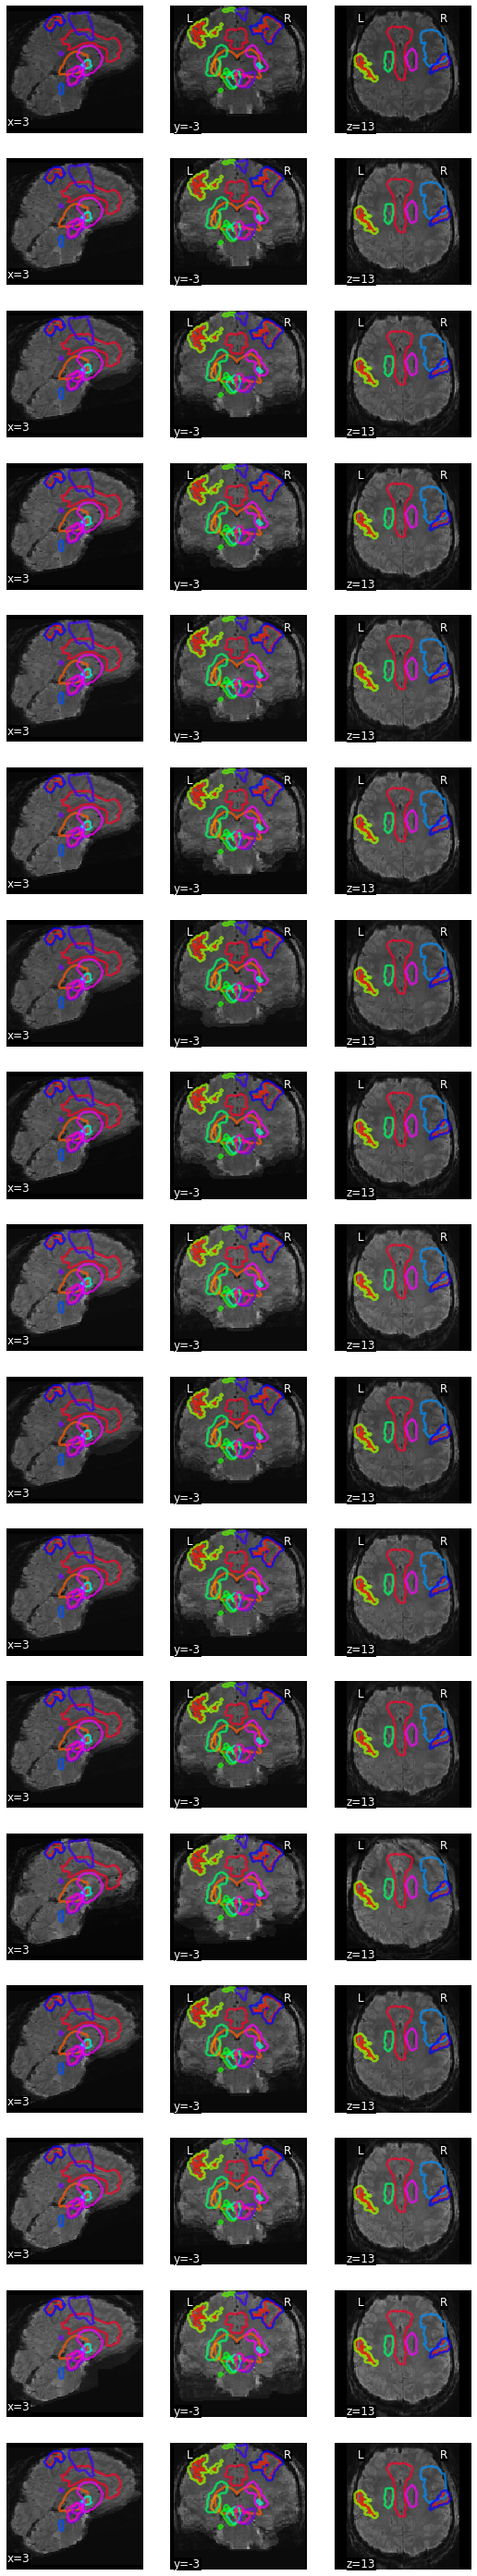

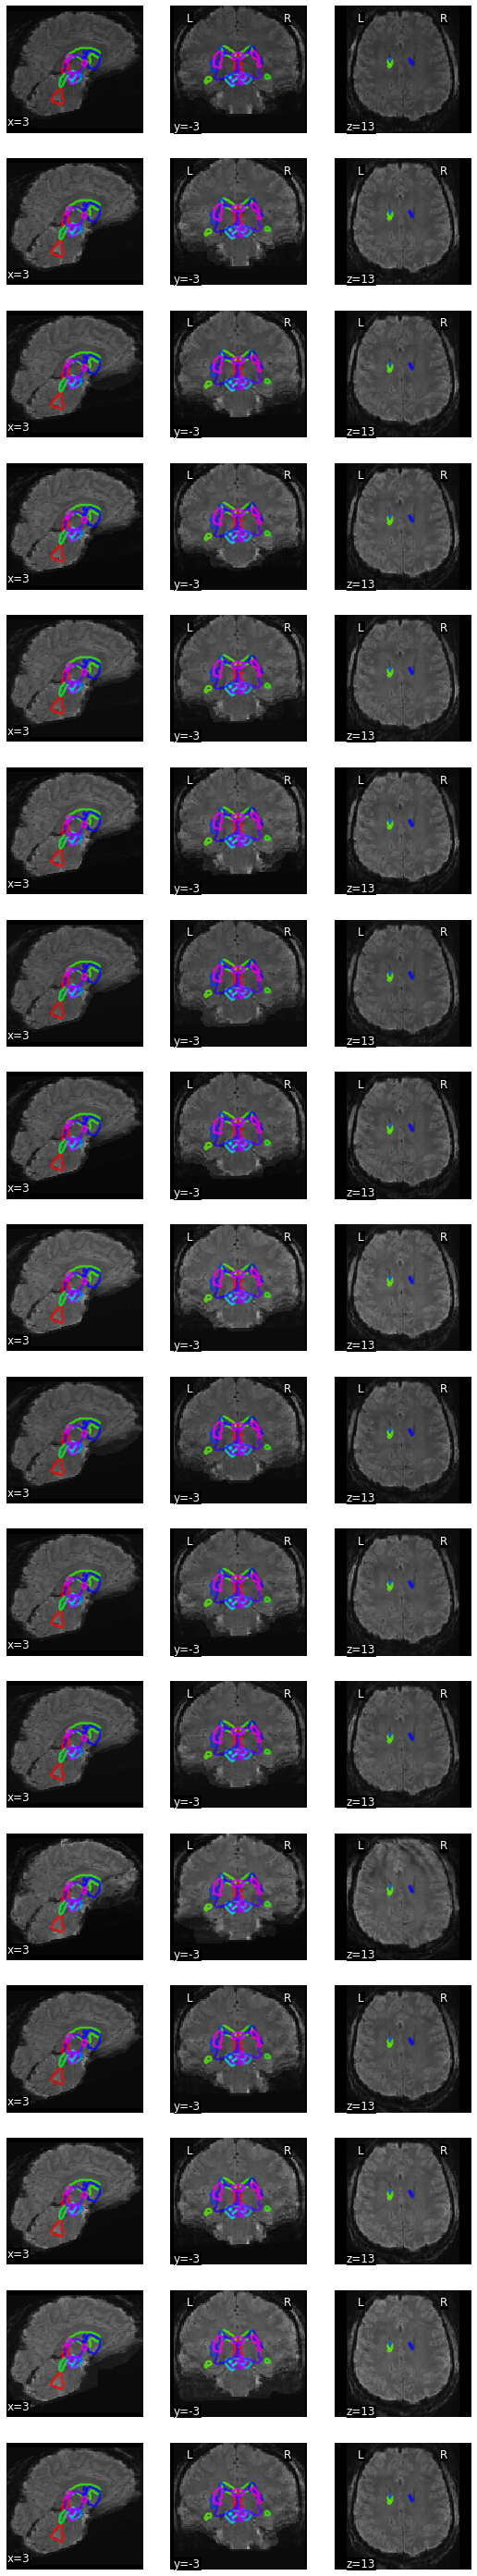

In [6]:
all_boldrefs = sorted(glob.glob('../derivatives/fmriprep/fmriprep/sub-*/ses-*/func/sub*_space-T1w_boldref.nii.gz'))
regex = re.compile('.*sub-(?P<sub>\d+)_ses-(?P<ses>\S+)_task-(?P<task>\S+)_run-(?P<run>\d)_space-T1w_boldref.nii.gz')

# all_subs = [regex.match(x).groupdict()['sub'] for x in all_boldrefs]
# all_subs = np.unique(all_subs)

# sub = all_subs[0]

# all_subs = ['002','003','004','005','006','007','008','009','010','011']
# all_subs = ['012','013','014','015','016']
# all_subs = ['017','018','019','020','021']
# all_subs = ['022','023','024','025','026']
# all_subs = ['027','029','030','031','032']
all_subs = ['026']

# loop over subs
def plot_masks(sub):
    boldrefs = sorted(glob.glob(f'../derivatives/fmriprep/fmriprep/sub-{sub}/ses-*/func/sub*_space-T1w_boldref.nii.gz'))
#    boldrefs

    for atlas_type in ['ATAG', 'MASSP']:
        n_rows = len(boldrefs)
        f, ax = plt.subplots(n_rows,3, figsize=(3*3,n_rows*3))

        cut_coords={'x': 3, 'y': -3, 'z': 13}
        for i, boldref in enumerate(boldrefs):
            for ii, axis in enumerate(['x','y','z']):
#                print(f'{i} {ii}...', end='')
                nilearn.plotting.plot_prob_atlas(load_atlas(sub, atlas_name=atlas_type).maps, bg_img=boldref, axes=ax[i,ii], display_mode=axis, cut_coords=[cut_coords[axis]])
        f.savefig(f'../mask_figures/sub-{sub}_space-T1w_{atlas_type}_boldref.pdf', bbox_inches='tight')
        
out = joblib.Parallel(n_jobs=1, verbose=True)(joblib.delayed(plot_masks)(x) for x in all_subs)

In [ ]:
# all_boldrefs = sorted(glob.glob('../derivatives/fmriprep/fmriprep/sub-*/ses-*/func/sub*_space-T1w_boldref.nii.gz'))
# regex = re.compile('.*sub-(?P<sub>\d+)_ses-(?P<ses>\S+)_task-(?P<task>\S+)_run-(?P<run>\d)_space-T1w_boldref.nii.gz')

# #     t1w = nib.load('../derivatives/fmriprep/fmriprep/sub-{sub}/anat/sub-{sub}_desc-preproc_T1w.nii.gz')
# #     masks_t1w = nib.load('../derivatives/nighres/sub-{sub}/ses-{ses}/subcortex/sub-{sub}_ses-{ses}_massp-labels.nii.gz')
# #     plotting.plot_stat_map(masks_t1w, bg_img = t1w)
# #     plt.gcf().savefig('./mask_figures/sub-{sub}_ses-{ses}_')

# all_subs = [regex.match(x).groupdict()['sub'] for x in all_boldrefs]
# all_subs = np.unique(all_subs)


# # for boldref in all_boldrefs:
# #     gd = regex.match(boldref).groupdict()
# #     print(boldref)
# #     sub,ses,task,run = gd['sub'], gd['ses'], gd['task'], gd['run']
# #     boldref = f'../derivatives/fmriprep/fmriprep/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_space-T1w_boldref.nii.gz'
# #     nilearn.plotting.plot_prob_atlas(load_atlas(sub, atlas_name='ATAG').maps, bg_img=boldref)
# #     plt.gcf().savefig(f'../mask_figures/sub-{sub}_ses-{ses}_task-{task}_run-{run}_space-T1w_ATAG_boldref.pdf', bbox_inches='tight')

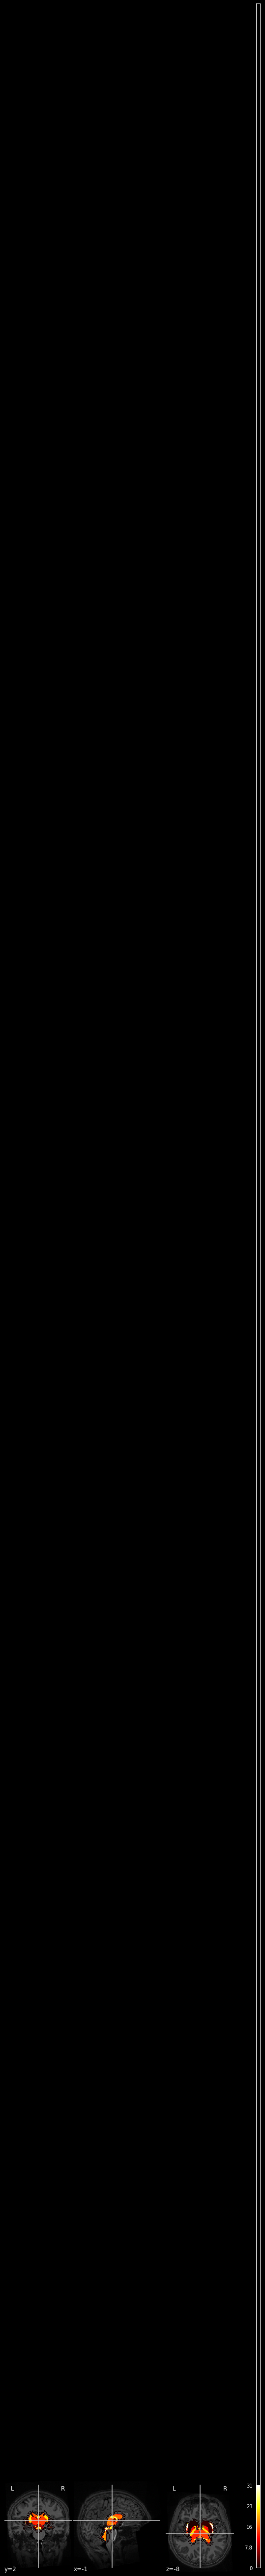

In [7]:
masks_t1w = nib.load('../derivatives/nighres/sub-026/ses-anatomical/subcortex/sub-026_ses-anatomical_massp-labels.nii.gz')
t1w = nib.load('../derivatives/fmriprep/fmriprep/sub-026/anat/sub-026_desc-preproc_T1w.nii.gz')
plotting.plot_stat_map(masks_t1w, bg_img=t1w)

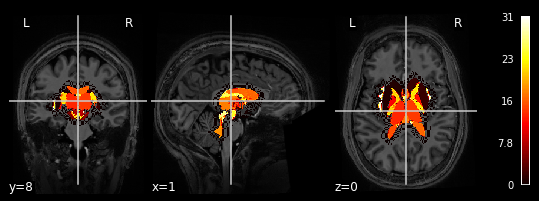

In [30]:
masks_t1w = nib.load('../derivatives/nighres/sub-004/ses-anatomical/subcortex/sub-004_ses-anatomical_massp-labels.nii.gz')
t1w = nib.load('../derivatives/fmriprep/fmriprep/sub-004/anat/sub-004_desc-preproc_T1w.nii.gz')
plotting.plot_stat_map(masks_t1w, bg_img=t1w)

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/nilearn/plotting/displays.py:103: UserWarning: No contour levels were found within the data range.
  **kwargs)


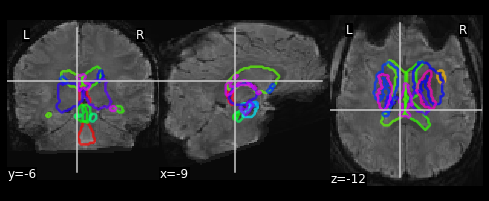

In [31]:
sub = '015'
boldref = sorted(glob.glob(f'../derivatives/fmriprep/fmriprep/sub-{sub}/ses-*/func/sub-{sub}_ses-*_task-*_run-*_space-T1w_boldref.nii.gz'))[3]
nilearn.plotting.plot_prob_atlas(load_atlas(sub).maps, bg_img=boldref)

/home/atrutti1/miniconda3/lib/python3.8/site-packages/nilearn/plotting/displays/_axes.py:71: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


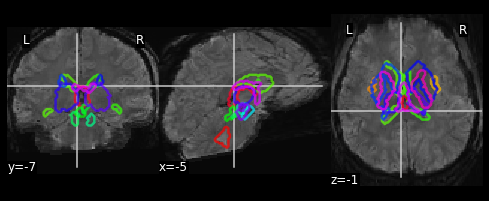

In [8]:
sub = '026'
boldref = sorted(glob.glob(f'../derivatives/fmriprep/fmriprep/sub-{sub}/ses-*/func/sub-{sub}_ses-*_task-*_run-*_space-T1w_boldref.nii.gz'))[3]
nilearn.plotting.plot_prob_atlas(load_atlas(sub).maps, bg_img=boldref)